100学生100题情况下，最佳w值使误差最小。使用pymc所求难度b。

In [288]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
np.random.seed(1234)
import pymc
import scipy.stats as stats
from scipy.optimize import minimize, rosen, rosen_der

-5432.19290796
 [-----------------100%-----------------] 100000 of 100000 complete in 247.9 sec-4524.64142988
0.627578871725 0.543190221056
0.556190450849 0.627255686343
0.7956
0.786253333665
[  0.0000e+00   0.0000e+00   1.3031e-04 ...,   9.9570e-01   9.9570e-01
   1.0000e+00]
[  4.2992e-04   1.2898e-03   1.2898e-03 ...,   9.9957e-01   1.0000e+00
   1.0000e+00]
[ 0.9332  0.9134  0.9017 ...,  0.0114  0.0113  0.0059]


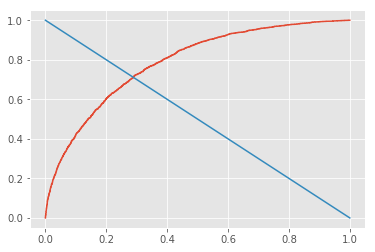

In [289]:
n_items=100
n_stu=100
# real_a = np.random.lognormal(0,0.2,(n_items,))
real_b1 = np.random.normal(0,1,(1,n_items))
real_theta1 = np.random.normal(0,1,(n_stu,1))
real_b2 = np.random.normal(0,1,(1,n_items))
real_theta2 = np.random.normal(0,1,(n_stu,1))
# uv=np.random.random((n_items,n_stu))<c + (1.0-c) / (1.0 + np.exp(-D*real_a*(real_theta-real_b)))
uv=np.random.random((n_stu,n_items))<1.0/ (1.0 + np.exp(-(real_theta1-real_b1)))/ (1.0 + np.exp(-(real_theta2-real_b2)))
mask=np.random.random(uv.shape)<0.7
def absm(a,b):
    return np.abs(a-b).mean()

def uirt(uv,mask):
    n_stu,n_items=uv.shape
    
    # 难度参数
    b1=pymc.Normal('b1',mu=0,tau=1,value=np.zeros((1,n_items,)))
    # 能力参数
    theta1=pymc.Normal('theta1',mu=0,tau=1,value=np.zeros((n_stu,1)))
    # 难度参数
    b2=pymc.Normal('b2',mu=0,tau=1,value=np.zeros((1,n_items,)))
    # 能力参数
    theta2=pymc.Normal('theta2',mu=0,tau=1,value=np.zeros((n_stu,1)))
    @pymc.deterministic
    def sigmoid(theta1=theta1,b1=b1,theta2=theta2,b2=b2): 
        return 1.0 / (1.0 + np.exp(-(theta1-b1)))/ (1.0 + np.exp(-(theta2-b2)))
    # 答题矩阵
    u=pymc.Bernoulli('u', p=sigmoid, value=uv, observed=True)
    
    params=[b1,theta1,b2,theta2,sigmoid]
    params.append(u)      

    m=pymc.MCMC(params)
    print u.logp
    m.sample(100000,40000,12)
    print u.logp
    eb1=np.array([b1.stats()['mean']])
    et1=np.array([theta1.stats()['mean']]).T
    eb2=np.array([b2.stats()['mean']])
    et2=np.array([theta2.stats()['mean']]).T
    m.stats()
    
    print absm(eb1.reshape(real_b1.shape),real_b1),absm(et1.reshape(real_theta1.shape),real_theta1)
    print absm(eb2.reshape(real_b2.shape),real_b2),absm(et2.reshape(real_theta2.shape),real_theta2)
    return eb1,et1,eb2,et2
eb1,et1,eb2,et2=uirt(uv,mask)
k = 0.5
uv_test=np.ones((n_stu,n_items))*k<1.0/ (1.0 + np.exp(-(et1-eb1)))/ (1.0 + np.exp(-(et2-eb2)))
result=uv_test==uv
print result.sum()/n_items/n_stu

from sklearn.metrics import roc_curve

uv_list = np.array([int(uvv) for uvv in uv.flat])+1
uv_test_list = np.array([int(uvv) for uvv in uv_test.flat])
uv_p = 1.0/ (1.0 + np.exp(-(et1-eb1)))/ (1.0 + np.exp(-(et2-eb2)))
uv_p_list = np.array([uvv for uvv in uv_p.flat])

fpr, tpr, thresholds = roc_curve(uv_list, uv_p_list, pos_label=2)

from sklearn.metrics import auc

plt.plot(fpr,tpr,label=thresholds)
plt.plot([0,1],[1,0])

print auc(fpr,tpr)

print fpr
print tpr
print thresholds
from sklearn.metrics import roc_auc_score

print roc_auc_score(uv_list, uv_p_list)

In [340]:
# b0 = np.array([ee for ee in real_b1.flat])
# b1 = np.array([ee for ee in real_b2.flat])
b0 = np.array([ee for ee in eb1.flat])
b1 = np.array([ee for ee in eb2.flat])
bnds = ((-3, 3), (-3, 3))
# r_funs=[]
# nit = 0
for w in [ii/100. for ii in range(100)]:
    r_fun = 0
    su = 0
    ab1 = []
    ab2 = []
    theta_min1 = []
    theta_min2 = []
    for i in range(100):
        y = np.array([ee for ee in uv[i].flat])
        fun = lambda x: sum(np.log(1+ np.exp(-(x[0]-b0)))+np.log(1+ np.exp(-(x[1]-b1)))-(1-y)*np.log((1+ np.exp(-(x[0]-b0)))*(1+ np.exp(-(x[1]-b1)))-1))/n_items+w*(x[0]**2+x[1]**2)
    #     fun = lambda x: sum(np.log(1+ np.exp(-(x[0]-b0)))+np.log(1+ np.exp(-(x[1]-b1)))-(1-y)*np.log((1+ np.exp(-(x[0]-b0)))*(1+ np.exp(-(x[1]-b1)))-1))
        res = minimize(fun, (et1[i][0],et2[i][0]), bounds=bnds,method='L-BFGS-B')
    #     res = minimize(fun, (et1[i][0],et2[i][0]), bounds=bnds,method='TNC')
    #     res = minimize(fun, (et1[i][0],et2[i][0]), bounds=bnds,method='SLSQP')
    #     res = minimize(fun, (et1[i][0],et2[i][0]),method='L-BFGS-B')
    #     res = minimize(fun, (et1[i][0],et2[i][0]),method='TNC')
    #     res = minimize(fun, (et1[i][0],et2[i][0]),method='SLSQP')
        r_fun += res.fun 
#         nit += res.nit
        # 存储t
        theta_min1.append(res.x[0])
        theta_min2.append(res.x[1])
        # 存储t的差值
        ab1.append(real_theta1[i][0]-res.x[0])
        ab2.append(real_theta2[i][0]-res.x[1])
        result = k<1.0/ (1.0 + np.exp(-(res.x[0]-b0)))/ (1.0 + np.exp(-(res.x[1]-b1)))
        su += sum(result==y)
    print w,su/100./100.,sum([abs(aa) for aa in ab1])/100.+sum([abs(aa) for aa in ab2])/100.,sum([abs(aa) for aa in ab1])/100.,sum([abs(aa) for aa in ab2])/100.,r_fun
# plt.hist(ab1,10, histtype='step', normed=True, label='post')
# plt.hist(ab2,100, histtype='step', normed=True, label='post')
#         plt.scatter(r_fun/100.)
#         print nit/100.
#         print su/100./100.

0.0 0.7988 2.3093058678 1.1852091816 1.12409668621 43.7428715286
0.01 0.7964 1.15655052143 0.529781238247 0.626769283181 45.2533551614
0.02 0.7937 1.18843900358 0.572715571489 0.615723432092 45.8390544163
0.03 0.7949 1.21317154738 0.598557712086 0.614613835294 46.2536098335
0.04 0.7935 1.23558749663 0.617645844571 0.617941652056 46.5756012866
0.05 0.7932 1.25676329628 0.634052378424 0.62271091786 46.8363839288
0.06 0.7923 1.27544487908 0.64704608178 0.628398797298 47.0531970799
0.07 0.7914 1.29188510382 0.657592990698 0.634292113127 47.2368897548
0.08 0.7899 1.30592639723 0.666648266157 0.639278131077 47.394818687
0.09 0.789 1.31867837279 0.67434858187 0.644329790915 47.5322207483
0.1 0.7881 1.32975458489 0.680992833052 0.648761751833 47.6529564317
0.11 0.7864 1.34008073338 0.686989484896 0.653091248488 47.7599491477
0.12 0.7856 1.34950037588 0.692323864104 0.657176511778 47.8554610413
0.13 0.7857 1.35820928584 0.697390670512 0.660818615324 47.9412742229
0.14 0.7848 1.36607401382 0.701

In [301]:
fun = np.sum(np.log(2)+np.log(2)-(1-uv)*np.log(3))
print fun

5432.19290796


(array([  7.,  11.,  14.,  24.,  23.,  14.,   4.,   2.,   0.,   1.]),
 array([-1.4167, -1.0712, -0.7256, -0.3801, -0.0345,  0.311 ,  0.6566,
         1.0021,  1.3477,  1.6932,  2.0388]),
 <a list of 1 Patch objects>)

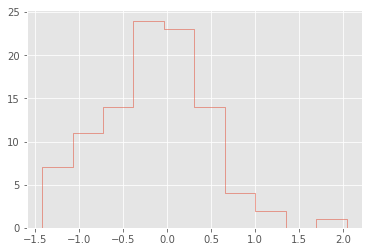

In [338]:
plt.hist(theta_min1,10, histtype='step', normed=False, label='post')

(array([  3.,   4.,  12.,  24.,  16.,  14.,  16.,   6.,   2.,   3.]),
 array([-1.5415, -1.238 , -0.9346, -0.6311, -0.3277, -0.0242,  0.2792,
         0.5827,  0.8862,  1.1896,  1.4931]),
 <a list of 1 Patch objects>)

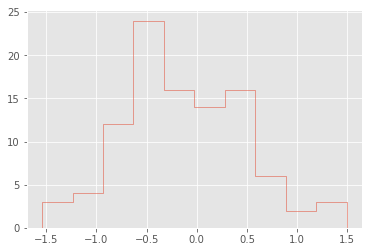

In [339]:
plt.hist(theta_min2,10, histtype='step', normed=False, label='post')

基本符合正太分布，数值偏向于大于3

In [331]:
a = np.cov(np.array([theta_min1,theta_min2]))
import math
print a
a[0][1]/math.sqrt(a[0][0])/math.sqrt(a[1][1])

[[ 0.375   0.1724]
 [ 0.1724  0.396 ]]


0.4474

最优化，误差偏大，相关性太大

In [315]:
a = np.cov(np.array([b0,b1]))
print a
a[0][1]/math.sqrt(a[0][0])/math.sqrt(a[1][1])

[[ 0.4377  0.2857]
 [ 0.2857  0.5462]]


0.5844

pymc计算结果，试题难度明显负相关

In [316]:
t0 = np.array([ee for ee in et1.flat])
t1 = np.array([ee for ee in et2.flat])
a = np.cov(np.array([t0,t1]))
print a
a[0][1]/math.sqrt(a[0][0])/math.sqrt(a[1][1])

[[ 0.4205  0.2297]
 [ 0.2297  0.4692]]


0.5170

pymc能力正相关，相关性大

In [298]:
t_real0 = np.array([ee for ee in real_theta1.flat])
t_real1 = np.array([ee for ee in real_theta2.flat])
a = np.cov(np.array([t_real0,t_real1]))
print a
a[0][1]/math.sqrt(a[0][0])/math.sqrt(a[1][1])

[[ 0.9672 -0.1218]
 [-0.1218  0.9145]]


-0.1295

真实数据能力不相关

In [299]:
b_real0 = np.array([ee for ee in real_b1.flat])
b_real1 = np.array([ee for ee in real_b2.flat])
a = np.cov(np.array([b_real0,b_real1]))
print a
a[0][1]/math.sqrt(a[0][0])/math.sqrt(a[1][1])

[[ 1.0014 -0.08  ]
 [-0.08    0.8948]]


-0.0845

真实数据难度不相关

In [341]:
real_theta1

array([[ 0.2912],
       [ 0.5665],
       [ 0.5036],
       [ 0.2853],
       [ 0.4843],
       [ 1.3635],
       [-0.7811],
       [-0.468 ],
       [ 1.2246],
       [-1.2811],
       [ 0.8755],
       [-1.7107],
       [-0.4508],
       [ 0.7492],
       [-0.2039],
       [-0.1822],
       [ 0.6807],
       [-1.8185],
       [ 0.0471],
       [ 0.3948],
       [-0.2484],
       [-0.6177],
       [-0.6829],
       [ 0.4363],
       [-1.703 ],
       [ 0.3937],
       [-0.4793],
       [-0.299 ],
       [ 0.6941],
       [ 0.6786],
       [ 0.2396],
       [ 0.1512],
       [ 0.8161],
       [ 1.8935],
       [ 0.6396],
       [-0.962 ],
       [-2.0853],
       [ 1.9302],
       [-1.7353],
       [ 1.2104],
       [ 0.7974],
       [-0.3798],
       [ 0.7026],
       [-0.8503],
       [ 1.1768],
       [-0.5243],
       [ 0.7009],
       [ 0.9842],
       [-0.1217],
       [ 2.3658],
       [ 0.4961],
       [ 0.7966],
       [-0.474 ],
       [-0.0567],
       [ 1.3578],
       [-0